<a href="https://colab.research.google.com/github/HJBJalaly/DLeeg/blob/master/best%20channel/Mine/Search_3Ch_Base_Normal_FitGenerate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install mne

     |████████████████████████████████| 6.4MB 2.9MB/s 


In [3]:
'''
Rivision:
980806:
  Differenet in/out shift Sampling
  The model is revised to addapt with fit_generate
  All Generators are merged.

  

'''

'\nRivision:\n980806:\n  Differenet in/out shift Sampling\n  The model is revised to addapt with fit_generate\n  All Generators are merged.\n\n  \n\n'

In [0]:
# Parameters:

EpochNum=25
subject_number=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1] # task: REO
Best1Channel=[61,36] #Oz
TryStr='Try1'


task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =8  # outer step len
window_len= 20
batch_size=64

Search_Space_Channel = [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
Search_Space_Channel_Name=["Fp1","Fp2","F7","F3","Fz","F4","F8","T7","C3","Cz","C4","T8","P7","P3","Pz","P4","P8","O1","Oz","O2"]

# Channel Indexes:
#   Fp1,21
#   Fp2,23
#   F7,29
#   F3,31
#   Fz,33
#   F4,35
#   F8,36
#   T7,40
#   C3,8
#   Cz,10
#   C4,12
#   T8,41
#   P7,46
#   P3,48
#   Pz,50
#   P4,52
#   P8,54
#   O1,60
#   Oz,61
#   O2,62

#   T9,42
#   T10,43


In [5]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import numpy as np
import math
import random

# For clear memory
import gc

#
import copy 
import csv
import pandas as pd
import datetime
import time
import os


# To download file from google drive
from google.colab import files

# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend


# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


Automatically created module for IPython interactive environment


In [6]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_number
for x in range(subject_number):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_number,task_number), dtype='object')

for i in range(subject_number):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


Do you want to set the path:
    /content/drive/My Drive/Deep Results/Database
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.in

In [0]:
# img for each subject
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)



train_index = len(subject_img_number_array_shuffled)//2
val_index = train_index + len(subject_img_number_array_shuffled)//4

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)


In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
        
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        for i in range(len(ListChannel)):
            DataChannelsRaw[s][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[s][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[s][i])) # min for each cannel

            DataChannelsNormal[s][i]=normalize_channel_data(DataChannelsRaw[s][i].copy(), i, ch_min, ch_max)


        # make Channels Orthogonal
        DataChannelsOrt[s][0]=DataChannelsNormal[s][0]
        DataChannelsOrt[s][1]=DataChannelsNormal[s][1]-ProjectionVector(DataChannelsOrt[s][0].copy(),DataChannelsNormal[s][1].copy())*OrthogonalFlag
        DataChannelsOrt[s][2]=DataChannelsNormal[s][2]-ProjectionVector(DataChannelsOrt[s][0].copy(),DataChannelsNormal[s][2].copy())*OrthogonalFlag\
                                                      -ProjectionVector(DataChannelsOrt[s][1].copy(),DataChannelsNormal[s][2].copy())*OrthogonalFlag

        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerSec), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsOrt[s][i][0+j*OuterSampleShift + z*InnerSampleShift:SampelNumberPerSec+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,len(SubjectArrayShuffled))
                yield TrainImage, TrainLabelClass 

                

#################################################################################################
Index: 0  > Channel: Fp1
  Already Done.
#################################################################################################
Index: 1  > Channel: Fp2
  Already Done.
#################################################################################################
Index: 2  > Channel: F7
  Already Done.
#################################################################################################
Index: 3  > Channel: F3
  Already Done.
#################################################################################################
Index: 4  > Channel: Fz
  Already Done.
#################################################################################################
Index: 5  > Channel: F4
  Already Done.
#################################################################################################
Index: 6  > Channel: F8
  Already Done.
################################

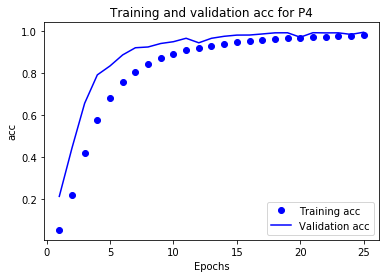


#################################################################################################
Index: 16  > Channel: P8
Epoch 1/25
997/997 [==============================] - 39s 40ms/step - loss: 4.1847 - acc: 0.0589 - val_loss: 3.2876 - val_acc: 0.2061
Epoch 2/25
997/997 [==============================] - 37s 37ms/step - loss: 2.9676 - acc: 0.2169 - val_loss: 2.0481 - val_acc: 0.5034
Epoch 3/25
997/997 [==============================] - 37s 37ms/step - loss: 2.0283 - acc: 0.4158 - val_loss: 1.2848 - val_acc: 0.6887
Epoch 4/25
997/997 [==============================] - 37s 37ms/step - loss: 1.4168 - acc: 0.5742 - val_loss: 0.8999 - val_acc: 0.7504
Epoch 5/25
997/997 [==============================] - 37s 37ms/step - loss: 1.0189 - acc: 0.6836 - val_loss: 0.5857 - val_acc: 0.8441
Epoch 6/25
997/997 [==============================] - 37s 37ms/step - loss: 0.7769 - acc: 0.7570 - val_loss: 0.4534 - val_acc: 0.8780
Epoch 7/25
997/997 [==============================] - 37s 37ms/step - lo

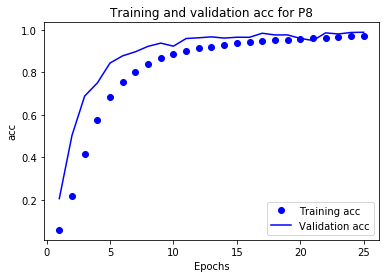

#################################################################################################
Index: 17  > Channel: O1
Epoch 1/25
997/997 [==============================] - 39s 39ms/step - loss: 4.2312 - acc: 0.0644 - val_loss: 3.3534 - val_acc: 0.2305
Epoch 2/25
997/997 [==============================] - 37s 37ms/step - loss: 3.1065 - acc: 0.2071 - val_loss: 2.3286 - val_acc: 0.4298
Epoch 3/25
997/997 [==============================] - 37s 37ms/step - loss: 2.2244 - acc: 0.3785 - val_loss: 1.5286 - val_acc: 0.6075
Epoch 4/25
997/997 [==============================] - 37s 37ms/step - loss: 1.6284 - acc: 0.5186 - val_loss: 1.0714 - val_acc: 0.7166
Epoch 5/25
997/997 [==============================] - 37s 37ms/step - loss: 1.2476 - acc: 0.6194 - val_loss: 0.9498 - val_acc: 0.7293
Epoch 6/25
997/997 [==============================] - 37s 37ms/step - loss: 0.9684 - acc: 0.6997 - val_loss: 0.5435 - val_acc: 0.8579
Epoch 7/25
997/997 [==============================] - 37s 37ms/step - los

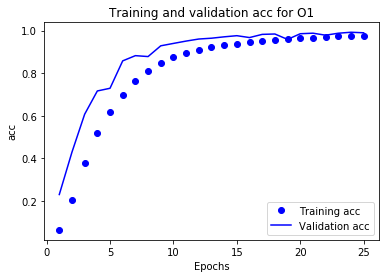

#################################################################################################
Index: 18  > Channel: Oz
  Same channel as previously selected channels.
#################################################################################################
Index: 19  > Channel: O2
Epoch 1/25
997/997 [==============================] - 40s 40ms/step - loss: 4.2631 - acc: 0.0527 - val_loss: 3.4922 - val_acc: 0.1663
Epoch 2/25
997/997 [==============================] - 37s 37ms/step - loss: 3.1568 - acc: 0.1921 - val_loss: 2.3487 - val_acc: 0.4146
Epoch 3/25
997/997 [==============================] - 37s 37ms/step - loss: 2.1518 - acc: 0.3917 - val_loss: 1.3930 - val_acc: 0.6434
Epoch 4/25
997/997 [==============================] - 38s 38ms/step - loss: 1.4529 - acc: 0.5642 - val_loss: 0.8850 - val_acc: 0.7680
Epoch 5/25
997/997 [==============================] - 38s 38ms/step - loss: 1.0212 - acc: 0.6832 - val_loss: 0.5303 - val_acc: 0.8657
Epoch 6/25
997/997 [================

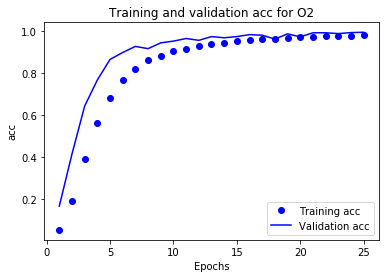

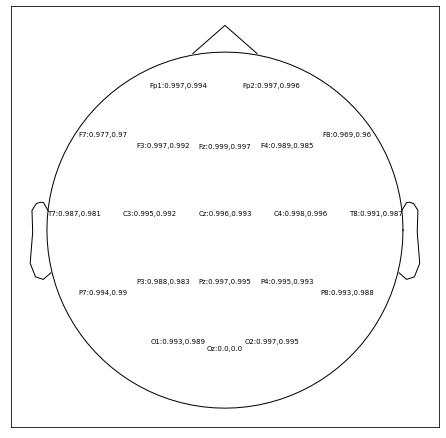

In [10]:
#####################################################################################################
# seacrh all channels


# Read Previous intruppted execution, if any, or create new empty cell
ResultFileName='SearchSpaceResultTable_3Ch_('+str(Best1Channel[0])+'_'+str(Best1Channel[1])+')_S'+str(subject_number)
if RemoveBaseLine==0:
  ResultFileName=ResultFileName+"_RemoveBaseLineOff"
else:
  ResultFileName=ResultFileName+"_RemoveBaseLineOn"

if Orthogonal==0:
  ResultFileName=ResultFileName+"_OrthogonalOff"
else:
  ResultFileName=ResultFileName+"_OrthogonalOn"
  
ResultFileName=ResultFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'.csv'

  
if os.path.isfile('/content/drive/My Drive/Deep Results/'+ResultFileName):
#   print("here")
  SearchSpaceResult=pd.read_csv('/content/drive/My Drive/Deep Results/'+ResultFileName, header=None)
#   print(Test)
  SearchSpaceResult=SearchSpaceResult.values
#   print(Test)
  
else:
    SearchSpaceResult=np.zeros((len(Search_Space_Channel),6),dtype = float)



#####################################################################################################
# seacrh all channels

for IndexCh in range(len(Search_Space_Channel)):
    
    #################################################################################################
    # Print Iteration
    print("#################################################################################################")
    print("Index:", IndexCh," > Channel:", Search_Space_Channel_Name[IndexCh])
    
    if(SearchSpaceResult[IndexCh][0]>0):
      print("  Already Done.")
      continue 
    
    
    if(Search_Space_Channel[IndexCh]==Best1Channel[0] or Search_Space_Channel[IndexCh]==Best1Channel[1]):
      print("  Same channel as previously selected channels.")
      SearchSpaceResult[IndexCh][0]=.1
      continue
      
    
    #################################################################################################
    # Reset Model and Data Arrays
    list_channel=Best1Channel + [Search_Space_Channel[IndexCh]]
    ch_number=len(list_channel)
    
    list_rawdataTemp=list_rawdata.copy()

        
    #################################################################################################
    # Construct Data Generator

    GenTrainData=GenerateGeneralData(BatchSize=batch_size,
                                     ListRawDataMain=list_rawdataTemp.copy(),
                                     SubjectArrayShuffled=subject_number_array_shuffled,
                                     ListChannel=list_channel,
                                     RemoveBaseLineFlag=RemoveBaseLine,
                                     OrthogonalFlag=Orthogonal,
                                     WindowLen=window_len,
                                     OuterSampleShift=outer_sample_shift,
                                     InnerSampleShift=inner_sample_shift,
                                     SampelNumberPerSec=sampel_number_per_sec,
                                     ImageArrayShuffled=train_shuff)

    GenValidationData =GenerateGeneralData(BatchSize=batch_size,
                                           ListRawDataMain=list_rawdataTemp.copy(),
                                           SubjectArrayShuffled=subject_number_array_shuffled,
                                           ListChannel=list_channel,
                                           RemoveBaseLineFlag=RemoveBaseLine,
                                           OrthogonalFlag=Orthogonal,
                                           WindowLen=window_len,
                                           OuterSampleShift=outer_sample_shift,
                                           InnerSampleShift=inner_sample_shift,
                                           SampelNumberPerSec=sampel_number_per_sec,
                                           ImageArrayShuffled=val_shuff)

    GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                    ListRawDataMain=list_rawdataTemp.copy(),
                                    SubjectArrayShuffled=subject_number_array_shuffled,
                                    ListChannel=list_channel,
                                    RemoveBaseLineFlag=RemoveBaseLine,
                                    OrthogonalFlag=Orthogonal,
                                    WindowLen=window_len,
                                    OuterSampleShift=outer_sample_shift,
                                    InnerSampleShift=inner_sample_shift,
                                    SampelNumberPerSec=sampel_number_per_sec,
                                    ImageArrayShuffled=test_shuff)

    #################################################################################################
    # Create Model
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(subject_number, activation = 'softmax'))
    
    model.compile(loss= 'categorical_crossentropy',
                  optimizer= optimizers.RMSprop(lr= 1e-4),
                  metrics = ['acc'])
    
    #################################################################################################
    # Train the Model
    history = model.fit_generator(epochs =EpochNum,
                                  generator=GenTrainData,
                                  steps_per_epoch=np.ceil(train_number*subject_number/batch_size),
                                  validation_data=GenValidationData,
                                  validation_steps =np.ceil(val_number*subject_number/batch_size),
                                  use_multiprocessing=False,
                                  workers=1)

    #################################################################################################
    # Evalute the Model
    TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
    ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
    TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
    print('     TrainResult ([loss , acc])=',TrainResult)
    print('ValidationResult ([loss , acc])=',ValidationResult)
    print('      TestResult ([loss , acc])=',TestResult)
    
    #################################################################################################
    # Extract Result
    #SearchSpaceResult[IndexCh][0]=history.history['loss'][EpochNum-1]
    #SearchSpaceResult[IndexCh][1]=history.history['acc'][EpochNum-1]
    #SearchSpaceResult[IndexCh][2]=history.history['val_loss'][EpochNum-1]
    #SearchSpaceResult[IndexCh][3]=history.history['val_acc'][EpochNum-1]
    
    SearchSpaceResult[IndexCh][0]=TrainResult[0]
    SearchSpaceResult[IndexCh][1]=TrainResult[1]
    SearchSpaceResult[IndexCh][2]=ValidationResult[0]
    SearchSpaceResult[IndexCh][3]=ValidationResult[1]
    SearchSpaceResult[IndexCh][4]=TestResult[0]
    SearchSpaceResult[IndexCh][5]=TestResult[1]
    
    #################################################################################################
    # Save current Result to google drive
    with open('/content/drive/My Drive/Deep Results/'+ResultFileName, 'w+') as csvfile:
      spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
      spamwriter.writerows(SearchSpaceResult)


    #################################################################################################
    # plot accuracy
    history_dict = history.history 
    acc_values = history_dict ['acc'] 
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(acc_values) + 1)


    #plt.clf()
    plt.plot(epochs, acc_values, 'bo', label='Training acc') 
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
    plt.title('Training and validation acc for '+ Search_Space_Channel_Name[IndexCh]) 
    plt.xlabel('Epochs') 
    plt.ylabel('acc') 
    plt.legend()
    plt.show()

    #################################################################################################
    # Erase Memory
    KerasBackend.clear_session()
    
    del model
    del history
    del TrainResult
    del ValidationResult
    del TestResult
    del GenTrainData
    del GenValidationData
    del GenTestData
    
    KerasBackend.clear_session()
    
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    
#################################################################################################    
## Visualize Results and Save Results
Today = datetime.date.today()
TodayStr = Today.strftime("%Y%m%d")
ResultFileName='SearchSpaceResult_3Ch_('+str(Best1Channel[0])+'_'+str(Best1Channel[1])+')_S'+str(subject_number)
ChannelFileName='ChannelNames_3Ch_('+str(Best1Channel[0])+'_'+str(Best1Channel[1])+')_S'+str(subject_number)
ImageFileName='SearchSpaceResult_3Ch_('+str(Best1Channel[0])+'_'+str(Best1Channel[1])+')_S'+str(subject_number)

if RemoveBaseLine==0:
  ResultFileName=ResultFileName+'_RemoveBaseLineOff'
  ChannelFileName=ChannelFileName+'_RemoveBaseLineOff'
  ImageFileName=ImageFileName+'_RemoveBaseLineOff'
else:
  ResultFileName=ResultFileName+'_RemoveBaseLineOn'
  ChannelFileName=ChannelFileName+'_RemoveBaseLineOn'
  ImageFileName=ImageFileName+'_RemoveBaseLineOn'

if Orthogonal==0:
  ResultFileName=ResultFileName+"_OrthogonalOff"
  ChannelFileName=ChannelFileName+'_OrthogonalOff'
  ImageFileName=ImageFileName+'_OrthogonalOff'
else:
  ResultFileName=ResultFileName+"_OrthogonalOn"
  ChannelFileName=ChannelFileName+'_OrthogonalOn'
  ImageFileName=ImageFileName+'_OrthogonalOn'
  

ResultFileName=ResultFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+TodayStr+'.csv'
ChannelFileName=ChannelFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+TodayStr+'.csv'
ImageFileName=ImageFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+TodayStr+'.pdf'


# Visualize
biosemi_layout = mne.channels.read_layout('biosemi')
biosemi_Acc=copy.deepcopy(biosemi_layout)

for i in range(len(biosemi_Acc.names)):
    biosemi_Acc.names[i]=' '

    
for i in range(len(Search_Space_Channel)):
    index=biosemi_layout.names.index(Search_Space_Channel_Name[i])
    biosemi_Acc.names[index]=biosemi_layout.names[index]+":"+str(np.round(SearchSpaceResult[i][1],3))+\
                                                         ","+str(np.round(SearchSpaceResult[i][5],3))

ImageEEG=biosemi_Acc.plot()
# plt.title("Channel Name : Training Acc.  > Test Acc.",pad=-12)



# Save To Google Drive
ImageEEG.savefig('/content/drive/My Drive/Deep Results/'+ImageFileName)


with open('/content/drive/My Drive/Deep Results/'+ResultFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(SearchSpaceResult)

with open('/content/drive/My Drive/Deep Results/'+ChannelFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(Search_Space_Channel)
    spamwriter.writerow(Search_Space_Channel_Name)

    

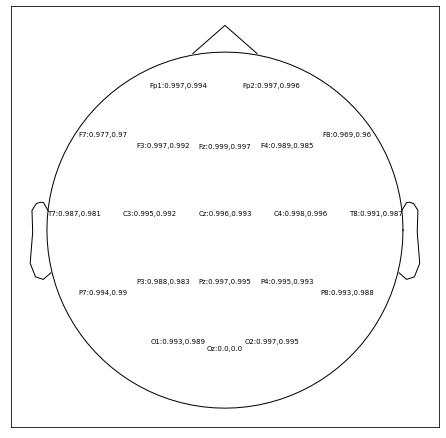

KeyboardInterrupt: ignored

In [11]:
## Visualize Results and Save Results
Today = datetime.date.today()
TodayStr = Today.strftime("%Y%m%d")
ResultFileName='SearchSpaceResult_3Ch_('+str(Best1Channel[0])+'_'+str(Best1Channel[1])+')_S'+str(subject_number)
ChannelFileName='ChannelNames_3Ch_('+str(Best1Channel[0])+'_'+str(Best1Channel[1])+')_S'+str(subject_number)
ImageFileName='SearchSpaceResult_3Ch_('+str(Best1Channel[0])+'_'+str(Best1Channel[1])+')_S'+str(subject_number)

if RemoveBaseLine==0:
  ResultFileName=ResultFileName+'_RemoveBaseLineOff'
  ChannelFileName=ChannelFileName+'_RemoveBaseLineOff'
  ImageFileName=ImageFileName+'_RemoveBaseLineOff'
else:
  ResultFileName=ResultFileName+'_RemoveBaseLineOn'
  ChannelFileName=ChannelFileName+'_RemoveBaseLineOn'
  ImageFileName=ImageFileName+'_RemoveBaseLineOn'


if Orthogonal==0:
  ResultFileName=ResultFileName+"_OrthogonalOff"
  ChannelFileName=ChannelFileName+'_OrthogonalOff'
  ImageFileName=ImageFileName+'_OrthogonalOff'
else:
  ResultFileName=ResultFileName+"_OrthogonalOn"
  ChannelFileName=ChannelFileName+'_OrthogonalOn'
  ImageFileName=ImageFileName+'_OrthogonalOn'
    
ResultFileName=ResultFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+TodayStr+'.csv'
ChannelFileName=ChannelFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+TodayStr+'.csv'
ImageFileName=ImageFileName+'_SamplesIn'+str(inner_sample_shift)+'Out'+str(outer_sample_shift)+'_'+TryStr+'_'+TodayStr+'.pdf'


# Visualize
biosemi_layout = mne.channels.read_layout('biosemi')
biosemi_Acc=copy.deepcopy(biosemi_layout)

for i in range(len(biosemi_Acc.names)):
    biosemi_Acc.names[i]=' '

    
for i in range(len(Search_Space_Channel)):
    index=biosemi_layout.names.index(Search_Space_Channel_Name[i])
    biosemi_Acc.names[index]=biosemi_layout.names[index]+":"+str(np.round(SearchSpaceResult[i][1],3))+\
                                                         ","+str(np.round(SearchSpaceResult[i][5],3))

ImageEEG=biosemi_Acc.plot()
# plt.title("Channel Name : Training Acc.  > Test Acc.",pad=-12)


# Save
ImageEEG.savefig(ImageFileName)

with open(ResultFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(SearchSpaceResult)

with open(ChannelFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(Search_Space_Channel)
    spamwriter.writerow(Search_Space_Channel_Name)
    
# Downlaod
import os
while os.path.isfile(ResultFileName)==False:
  print('wait')
  time.sleep(1)

files.download(ResultFileName)
files.download(ChannelFileName)
files.download(ImageFileName)